# **Exploring the European Soccer Database with SQL**

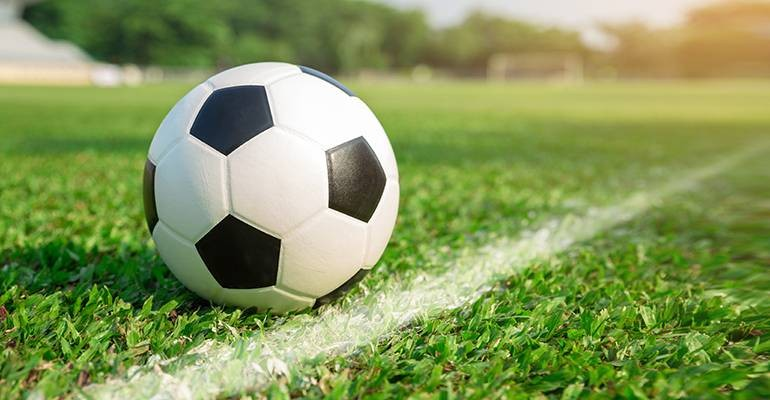

In this notebook I showcase some of the advanced SQL skills I've learned in an online course on [DataCamp](https://app.datacamp.com/learn/courses/intermediate-sql).<br>

To demonstrate my skills I focus on the following techniques:

1. `CASE WHEN` statements
2. Correlated Queries
3. Nested Queries
4. Common Table Expressions

Database can be found on [Kaggle](https://www.kaggle.com/hugomathien/soccer). The notebook is made ready to run on kaggle, once uploaded.

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import sqlite3

# Connect to database

In [2]:
path = "../input/soccer" 
database = path + 'database.sqlite'

conn = sqlite3.connect('../input/soccer/database.sqlite')
cursor = conn.cursor()

## Explore tables
Tables contain information about 
1. Players 
2. Teams
3. Matches
4. Country

In [3]:
# Get all tables from the database
tables = pd.read_sql(
    """SELECT * FROM sqlite_master WHERE type = 'table';""", conn)
print('Tables:')
tables

Tables:


,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [4]:
# Explore Team table
print("Team table:")
display(pd.read_sql(
    """
    SELECT * FROM Team LIMIT 5""", conn))

# Explore Counter table
print("Country table:")
display(pd.read_sql(
    """
    SELECT * FROM Country LIMIT 5;""", conn))

# Explore team attributes
print("League:")
display(pd.read_sql(
    """
    SELECT * FROM League LIMIT 5;""", conn))

# Explore Match table
print("Match:")
display(pd.read_sql(
    """
    SELECT * FROM Match LIMIT 5;""", conn))

print("Spain id:")
cursor.execute(
    """
    Select id FROM Country WHERE name = 'Spain';""")
cursor.fetchall()[0][0]

Team table:


,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673,KRC Genk,GEN
1,2,9993,675,Beerschot AC,BAC
2,3,10000,15005,SV Zulte-Waregem,ZUL
3,4,9994,2007,Sporting Lokeren,LOK
4,5,9984,1750,KSV Cercle Brugge,CEB


Country table:


,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy


League:


,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A


Match:


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


Spain id:


21518

In [5]:
# Extract matches hosted in spain
cursor.execute(
    """
    CREATE TEMPORARY TABLE matches_spain AS
    SELECT 
        id, country_id, season, stage, date, 
        home_team_api_id AS hometeam_id, 
        away_team_api_id AS awayteam_id, 
        home_team_goal AS home_goal, 
        away_team_goal AS away_goal
    FROM Match
    WHERE country_id = 21518
    """)

# Data Exploration
## `CASE WHEN`

Construct a query to determine the outcome of Barcelona's matches where they played as the away team.

In [6]:
pd.read_sql(
    """
    -- Select matches where Barcelona was the away team
    SELECT  
        m.date,
        t.team_long_name AS opponent,
        CASE WHEN m.home_goal < m.away_goal THEN 'Barcelona win!'
            WHEN m.home_goal > m.away_goal THEN 'Barcelona loss :(' 
            ELSE 'Tie' END AS outcome
    FROM matches_spain AS m
    -- Join teams_spain to matches_spain
    LEFT JOIN Team AS t 
    ON m.hometeam_id = t.team_api_id
    WHERE m.awayteam_id = 8634
    LIMIT 5;
    """, conn)

,date,opponent,outcome
0,2008-08-31 00:00:00,CD Numancia,Barcelona loss :(
1,2008-11-16 00:00:00,RC Recreativo,Barcelona win!
2,2008-11-29 00:00:00,Sevilla FC,Barcelona win!
3,2008-12-21 00:00:00,Villarreal CF,Barcelona win!
4,2009-01-11 00:00:00,CA Osasuna,Barcelona win!


Barcelona and Real Madrid have been rival teams for more than 80 years. Matches between those two teams are given the name El Clásico (The Classic). The next cell retrieves information about matches played between Barcelona `id = 8634` and Real Madrid `id = 8633`

In [7]:
pd.read_sql(
    """
    SELECT 
        date,
        -- Identify the home team as Barcelona or Real Madrid
        CASE WHEN hometeam_id = 8634 THEN 'FC Barcelona' 
            ELSE 'Real Madrid CF' END AS home,
        -- Identify the away team as Barcelona or Real Madrid
        CASE WHEN awayteam_id = 8634 THEN 'FC Barcelona' 
            ELSE 'Real Madrid CF' END AS away
    FROM matches_spain
    WHERE (awayteam_id = 8634 OR hometeam_id = 8634)
          AND (awayteam_id = 8633 OR hometeam_id = 8633); """, conn)

,date,home,away
0,2008-12-13 00:00:00,FC Barcelona,Real Madrid CF
1,2009-05-02 00:00:00,Real Madrid CF,FC Barcelona
2,2009-11-29 00:00:00,FC Barcelona,Real Madrid CF
3,2010-04-10 00:00:00,Real Madrid CF,FC Barcelona
4,2010-11-29 00:00:00,FC Barcelona,Real Madrid CF
5,2011-04-16 00:00:00,Real Madrid CF,FC Barcelona
6,2011-12-10 00:00:00,Real Madrid CF,FC Barcelona
7,2012-04-21 00:00:00,FC Barcelona,Real Madrid CF
8,2013-03-02 00:00:00,Real Madrid CF,FC Barcelona
9,2012-10-07 00:00:00,FC Barcelona,Real Madrid CF


Do the number of soccer matches played in a given European country differ across seasons? We will use the European Soccer Database to answer this question.

In [8]:
pd.read_sql(
    """
    SELECT 
	c.name AS country,
    -- Count matches in each of the 3 seasons
	COUNT(CASE WHEN m.season = '2012/2013' THEN m.id END) AS matches_2012_2013,
	COUNT(CASE WHEN m.season = '2013/2014' THEN m.id END) AS matches_2013_2014,
	COUNT(CASE WHEN m.season = '2014/2015' THEN m.id END) AS matches_2014_2015
    FROM Country AS c
    LEFT JOIN Match AS m
    ON c.id = m.country_id
    -- Group by country name alias
    GROUP BY c.name;""", conn)

,country,matches_2012_2013,matches_2013_2014,matches_2014_2015
0,Belgium,240,12,240
1,England,380,380,380
2,France,380,380,380
3,Germany,306,306,306
4,Italy,380,380,379
5,Netherlands,306,306,306
6,Poland,240,240,240
7,Portugal,240,240,306
8,Scotland,228,228,228
9,Spain,380,380,380


## Nested Quesries
What was the highest scoring match for each country, in each season?

In [9]:
# Sample a smaller version of the table to accomodate limited computation resources
cursor.execute(
    """
    CREATE TEMPORARY TABLE match AS
    SELECT 
        id, country_id, season, stage, date, 
        home_team_api_id AS hometeam_id, 
        away_team_api_id AS awayteam_id, 
        home_team_goal AS home_goal, 
        away_team_goal AS away_goal
    FROM Match
    WHERE id BETWEEN 757 AND 25799
    """)
pd.read_sql("""SELECT * FROM match LIMIT 5;""", conn)

,id,country_id,season,stage,date,hometeam_id,awayteam_id,home_goal,away_goal
0,757,1,2011/2012,1,2011-07-29 00:00:00,1773,8635,2,1
1,758,1,2011/2012,1,2011-07-30 00:00:00,9998,9985,1,1
2,759,1,2011/2012,1,2011-07-30 00:00:00,9987,9993,3,1
3,760,1,2011/2012,1,2011-07-30 00:00:00,9991,9984,0,1
4,761,1,2011/2012,1,2011-07-30 00:00:00,9994,10000,0,0


In [10]:
pd.read_sql(
    """
    SELECT 
	-- Select country ID, date, home, and away goals from match
	main.country_id,
    main.date,
    main.home_goal,
    main.away_goal
    FROM match AS main
    WHERE 
	-- Filter for matches with the highest number of goals scored
        (home_goal + away_goal) = 
            (SELECT MAX(sub.home_goal + sub.away_goal)
                 FROM match AS sub
                 WHERE main.country_id = sub.country_id AND main.season = sub.season)
    LIMIT 10;""", conn)

,country_id,date,home_goal,away_goal
0,1,2011-10-29 00:00:00,4,5
1,1,2012-11-17 00:00:00,2,6
2,1,2012-12-09 00:00:00,1,7
3,1,2013-01-19 00:00:00,2,6
4,1,2012-08-19 00:00:00,2,6
5,1,2014-04-19 00:00:00,2,4
6,1,2014-04-26 00:00:00,4,2
7,1,2015-01-17 00:00:00,1,7
8,1,2014-09-13 00:00:00,3,5
9,1,2015-08-30 00:00:00,7,1


Examine the highest total number of goals in each season, overall, and during July across all seasons.

In [11]:
pd.read_sql(
    """
    SELECT
	-- Select the season and max goals scored in a match
	season,
    MAX(home_goal + away_goal) AS max_goals,
    -- Select the overall max goals scored in a match
   (SELECT MAX(home_goal + away_goal) FROM match) AS overall_max_goals,
   -- Select the max number of goals scored in any match in July
   (SELECT MAX(home_goal + away_goal) 
    FROM match
    WHERE id IN (SELECT id FROM match WHERE SUBSTR(date, 6, 2) = '07')) AS july_max_goals
    FROM match
    GROUP BY season
    LIMIT 5;""", conn)

,season,max_goals,overall_max_goals,july_max_goals
0,2008/2009,9,12,7
1,2009/2010,12,12,7
2,2010/2011,10,12,7
3,2011/2012,10,12,7
4,2012/2013,11,12,7


What's the average number of matches per season where a team scored 5 or more goals? How does this differ by country?

In [12]:
pd.read_sql(
    """
    SELECT
	c.name AS country,
    -- Calculate the average matches per season
	AVG(outer_s.matches) AS avg_seasonal_high_scores
    FROM Country AS c
    -- Left join outer_s to country
    LEFT JOIN (
      SELECT country_id, season,
             COUNT(id) AS matches
      FROM (
        SELECT country_id, season, id
        FROM match
        WHERE home_goal >= 5 OR away_goal >= 5) AS inner_s
      -- Close parentheses and alias the subquery
      GROUP BY country_id, season) AS outer_s
    ON c.id = outer_s.country_id
    GROUP BY country
    ORDER BY avg_seasonal_high_scores DESC;
    """, conn)

,country,avg_seasonal_high_scores
0,Netherlands,20.125000
1,Spain,19.125000
2,England,14.500000
3,Germany,13.750000
4,Belgium,10.500000
5,Portugal,8.625000
6,Italy,8.500000
7,France,8.000000
8,Switzerland,7.142857
9,Scotland,7.125000


## Common Expression Tables
Generate a list of countries and the number of matches in each country with more than 10 total goals.

In [13]:
pd.read_sql(
    """
    -- Set up CTE
    WITH match_list AS (
        SELECT 
            country_id, 
            id
        FROM match
        WHERE (home_goal + away_goal) >= 10)
    -- Select league and count of matches from the CTE
    SELECT
        l.name AS league,
        COUNT(match_list.id) AS matches
    FROM league AS l
    -- Join the CTE to the league table
    LEFT JOIN match_list ON l.id = match_list.country_id
    GROUP BY l.name;""", conn)

,league,matches
0,Belgium Jupiler League,0
1,England Premier League,4
2,France Ligue 1,1
3,Germany 1. Bundesliga,1
4,Italy Serie A,0
5,Netherlands Eredivisie,2
6,Poland Ekstraklasa,0
7,Portugal Liga ZON Sagres,0
8,Scotland Premier League,1
9,Spain LIGA BBVA,5


Extract details about matches with very high scores using Common Table Expressions (CTEs).

In [14]:
pd.read_sql(
    """
    -- Set up CTE
    WITH match_list AS (
    -- Select the league, date, home, and away goals
    SELECT 
  		l.name AS league, 
     	m.date, 
  		m.home_goal, 
  		m.away_goal,
       (m.home_goal + m.away_goal) AS total_goals
    FROM match AS m
    LEFT JOIN league as l ON m.country_id = l.id)
    -- Select the league, date, home, and away goals from the CTE
    SELECT league, date, home_goal, away_goal
    FROM match_list
    -- Filter by total goals
    WHERE total_goals >= 10;
    """, conn)


,league,date,home_goal,away_goal
0,England Premier League,2009-11-22 00:00:00,9,1
1,England Premier League,2011-08-28 00:00:00,8,2
2,England Premier League,2012-12-29 00:00:00,7,3
3,England Premier League,2013-05-19 00:00:00,5,5
4,France Ligue 1,2009-11-08 00:00:00,5,5
5,Germany 1. Bundesliga,2013-03-30 00:00:00,9,2
6,Netherlands Eredivisie,2010-10-24 00:00:00,10,0
7,Netherlands Eredivisie,2011-11-06 00:00:00,6,4
8,Scotland Premier League,2010-05-05 00:00:00,6,6
9,Spain LIGA BBVA,2013-10-30 00:00:00,7,3


## Correlated subqueries
Get both the home and away team names into one final query result?

In [15]:
pd.read_sql(
    """
    SELECT
    m.date,
    (SELECT team_long_name
     FROM team AS t
     WHERE t.team_api_id = m.hometeam_id) AS hometeam,
    -- Connect the team to the match table
    (SELECT team_long_name
     FROM team AS t
     WHERE t.team_api_id = m.awayteam_id) AS awayteam,
    -- Select home and away goals
     m.home_goal,
     m.away_goal
    FROM match AS m
    LIMIT 5;
    """, conn)


,date,hometeam,awayteam,home_goal,away_goal
0,2011-07-29 00:00:00,Oud-Heverlee Leuven,RSC Anderlecht,2,1
1,2011-07-30 00:00:00,RAEC Mons,Standard de Liège,1,1
2,2011-07-30 00:00:00,KRC Genk,Beerschot AC,3,1
3,2011-07-30 00:00:00,KAA Gent,KSV Cercle Brugge,0,1
4,2011-07-30 00:00:00,Sporting Lokeren,SV Zulte-Waregem,0,0


Get both the home and away team names into one final query result with CTEs.

In [16]:
pd.read_sql(
    """
    WITH home AS (
        SELECT m.id, m.date, 
             t.team_long_name AS hometeam, m.home_goal
        FROM match AS m
        LEFT JOIN team AS t 
        ON m.hometeam_id = t.team_api_id),
    -- Declare and set up the away CTE
    away AS (
        SELECT m.id, m.date, 
             t.team_long_name AS awayteam, m.away_goal
        FROM match AS m
        LEFT JOIN team AS t 
        ON m.awayteam_id = t.team_api_id)
    -- Select date, home_goal, and away_goal
    SELECT 
    home.date,
    home.hometeam,
    away.awayteam,
    home.home_goal,
    away.away_goal
    -- Join away and home on the id column
    FROM home
    INNER JOIN away
    ON home.id = away.id;
    """, conn)

,date,hometeam,awayteam,home_goal,away_goal
0,2011-07-29 00:00:00,Oud-Heverlee Leuven,RSC Anderlecht,2,1
1,2011-07-30 00:00:00,RAEC Mons,Standard de Liège,1,1
2,2011-07-30 00:00:00,KRC Genk,Beerschot AC,3,1
3,2011-07-30 00:00:00,KAA Gent,KSV Cercle Brugge,0,1
4,2011-07-30 00:00:00,Sporting Lokeren,SV Zulte-Waregem,0,0
...,...,...,...,...,...
25038,2014-09-23 00:00:00,FC Basel,FC Vaduz,3,1
25039,2014-09-23 00:00:00,FC Thun,FC Luzern,3,2
25040,2014-09-24 00:00:00,FC St. Gallen,Grasshopper Club Zürich,3,0
25041,2014-09-24 00:00:00,FC Zürich,FC Aarau,0,0
